# Volley (or racketball or beach-volley) simulation & probability distribution

This is a Jupyter notebook converted to blog post by [nbconvert](https://nbconvert.readthedocs.io/en/latest/). The notebook is [here](https://github.com/lucabol/sportsim/blob/main/volley.ipynb). To comment or contribute, please open an issue or a pull request on [the repository](https://github.com/lucabol/sportsim).

The aim is to discover the probability of winning a set/game/match in volleyball/beach volley/racketball/badmington/..., given the probability of winning a point. The model is based on the assumption that the probability of winning a point is constant and independent of the previous points. This is a simplification, but it is a good starting point to understand the game.

Later, we will derive analytical formulas and compare the results of the simulation with the analytical formulas.

Let's start with the simulation.

In [1]:
import random
import pandas as pd

def simulate_volley(a_win_prob=0.52, max_games=1000, sets_to_win=2, points_to_win_standard=21, points_to_win_last=15):
    """
    Simulate a volleyball match between two teams with given probabilities of winning a point.

    Parameters:
    a_win_prob (float): Probability of team A winning a point.
    max_games (int): Maximum number of games to simulate.
    sets_to_win (int): Number of sets to win the match.
    points_to_win_standard (int): Number of points to win a set unless it's the last set and we are tied.
    points_to_win_last (int): Number of points to win the last set if we are tied.
    """
    a_wins = b_wins = a_tot_points = b_tot_points = a_tot_sets = b_tot_sets = 0
    rows = []

    while a_wins + b_wins < max_games:
        a_sets = b_sets = 0

        while a_sets < sets_to_win and b_sets < sets_to_win:
            a_points = b_points = 0
            points_to_win = points_to_win_standard if a_sets + b_sets < 2 * sets_to_win - 1 else points_to_win_last

            while not (a_points >= points_to_win and a_points - b_points >= 2) and not (b_points >= points_to_win and b_points - a_points >= 2):
                flag = 1
                a_win_point = random.random() < a_win_prob
                if a_win_point:
                    a_points += 1; a_tot_points += 1
                if not a_win_point:
                    b_points += 1; b_tot_points += 1

                if a_points >= points_to_win and a_points - b_points >= 2:
                    a_sets += 1; a_tot_sets += 1; flag = 2
                if b_points >= points_to_win and b_points - a_points >= 2:
                    b_sets += 1; b_tot_sets += 1; flag = 2

                if a_sets == sets_to_win:
                    a_wins += 1; flag = 3
                if b_sets == sets_to_win:
                    b_wins += 1; flag = 3

                rows.append({'F': flag, 'P': int(a_win_point), 'AS': a_sets, 'BS': b_sets, 'AP': a_points, 'BP': b_points,  'AW': a_wins, 'BW': b_wins, 'ATS': a_tot_sets, 'BTS': b_tot_sets, 'ATP': a_tot_points, 'BTP': b_tot_points})

    return rows

## Check for convergence

Let's check that the various probabilities converge to a stable value.

          WP        SP        PP
92266  0.652  0.609325  0.520164


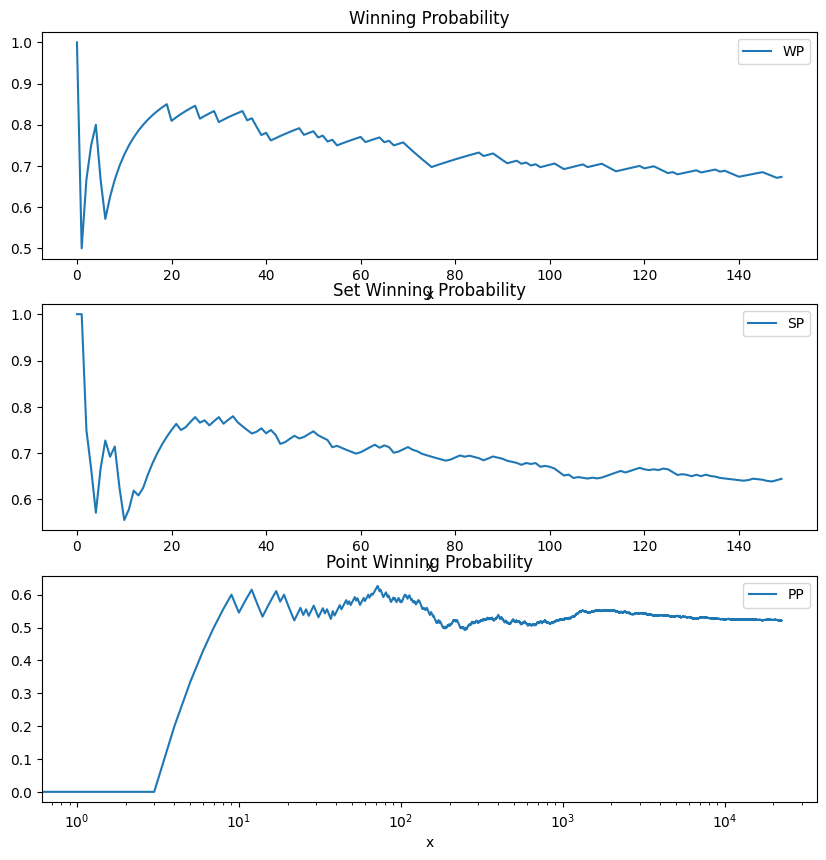

In [2]:
rows = simulate_volley(0.52)

df = pd.DataFrame(rows, columns=['F', 'P', 'AS', 'BS', 'AP', 'BP', 'AW', 'BW', 'ATS', 'BTS','ATP', 'BTP'])
df['WP'] = df['AW'] / (df['AW'] + df['BW'])
df['SP'] = df['ATS'] / (df['ATS'] + df['BTS'])
df['PP'] = df['ATP'] / (df['ATP'] + df['BTP'])

# Avoids SettingWithCopyWarning
pd.options.mode.copy_on_write = True

# Create a dataset containing just rows where Flag is 2
dfp = df[df['F'] == 1]
dfs = df[df['F'] == 2]
dfw = df[df['F'] == 3]

# Plot first N, N1 rows
N = 150
N1 = int(len(dfp['PP']) / 4)
dfw = dfw.head(N)
dfs = dfs.head(N)
dfp = dfp.head(N1)

# Create an increasing integer sequence for x-values
dfw['x'] = range(0, N)
dfs['x'] = range(0, N)
dfp['x']  = range(0, N1)

print(df[['WP', 'SP', 'PP']].tail(1))

# On the same plot, plot the winning probability, set winning probability, and point winning probability in time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

dfw.plot(x='x', y='WP', ax=ax[0], title='Winning Probability');
dfs.plot(x='x', y='SP', ax=ax[1], title='Set Winning Probability');
ax[2].set_xscale('log')
dfp.plot(x='x', y='PP', ax=ax[2], title='Point Winning Probability');

## Simulation
Then we simulate beach volley (2 sets to win, to 21 points each set except the last to 15) and volley (3 sets to win, to 25 each set except the last to 15).

The results look similar to the real data in [this blog post](https://garyhorvath.com/percentage-of-points-won-stanford-nebraska-and-cu-volleyball/)

We simulate just in the range of 0.5 to 0.65 for the probability of winning a point, as the probability of winning a set/match become 1 very quickly for higher values.

The results show two things:
- the probability of winning a set/match is not linear with the probability of winning a point and it is much higher. I.E. if you win 60% of the points, you win 90% of the sets and much more of the matches. Honestly, I was not expecting this, but it makes sense as the probability of winning a point gets multiplied many times, so small differences end up being very significant.
- the longer the set/match, the more the probability of winning a set/match is higher than the probability of winning a point, for the same reason as above (more chances for the better team to win points).

This code can be useful to figure out other characteristics of the game that might be difficult to model with the analytical formulas developed below.

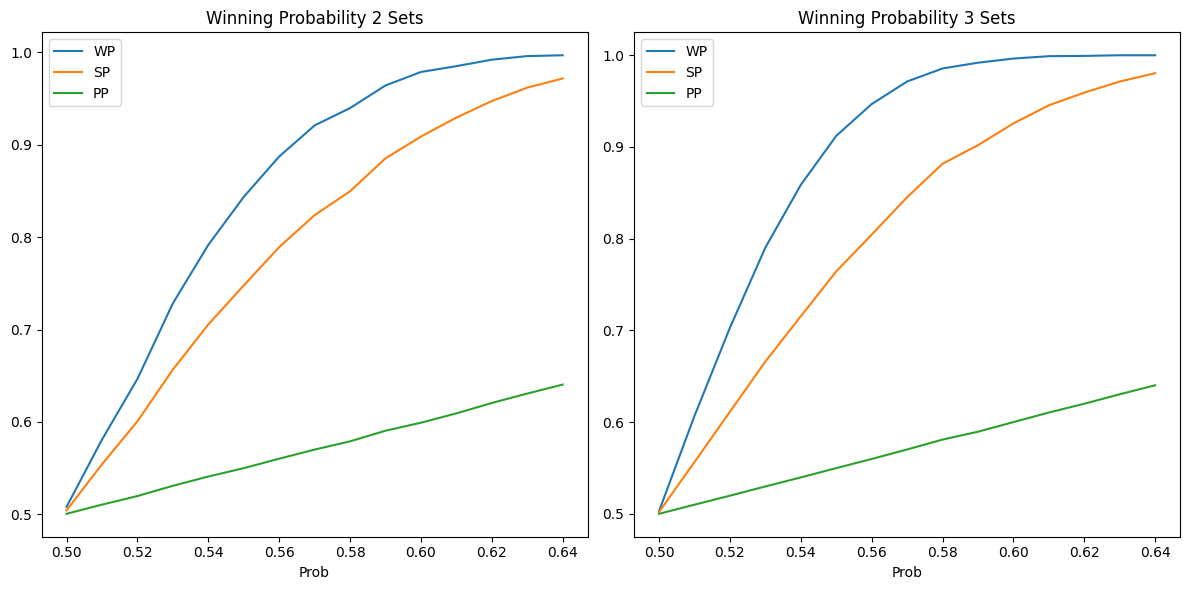

In [3]:
def simulate_volley_prob(low_prob=0.5, high_prob=0.6, step=0.01, max_games=10000, n_sets = 2, points_to_win_standard=21, points_to_win_last=15):
    result = []
    for i in range(int(low_prob * 100), int(high_prob * 100), int(step * 100)):
        rows = simulate_volley(i / 100, max_games=max_games, sets_to_win=n_sets, points_to_win_standard=points_to_win_standard, points_to_win_last=points_to_win_last)
        stats = rows[-1]
        result.append({'Prob': i / 100, 'WP': stats['AW'] / (stats['AW'] + stats['BW']),
                      'SP': stats['ATS'] / (stats['ATS'] + stats['BTS']),
                      'PP': stats['ATP'] / (stats['ATP'] + stats['BTP'])})
    return result

result_2sets = simulate_volley_prob(0.5, 0.65, 0.01, n_sets=2, points_to_win_standard=21, points_to_win_last=15)
result_3sets = simulate_volley_prob(0.5, 0.65, 0.01, n_sets=3, points_to_win_standard=25, points_to_win_last=15)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

df_2sets = pd.DataFrame(result_2sets)
df_2sets.plot(x='Prob', y=['WP', 'SP', 'PP'], title='Winning Probability 2 Sets', ax=axs[0]);

df_3sets = pd.DataFrame(result_3sets)
df_3sets.plot(x='Prob', y=['WP', 'SP', 'PP'], title='Winning Probability 3 Sets', ax=axs[1]);

plt.tight_layout()

## Fitting a function

Here we fit a function to the data in the interval shown. As it turns out, a sigmoid does so pretty well. This is a brute force empirically derived result. Maybe there is a theory behind it, but I don't know it.

The fit looks pretty good.

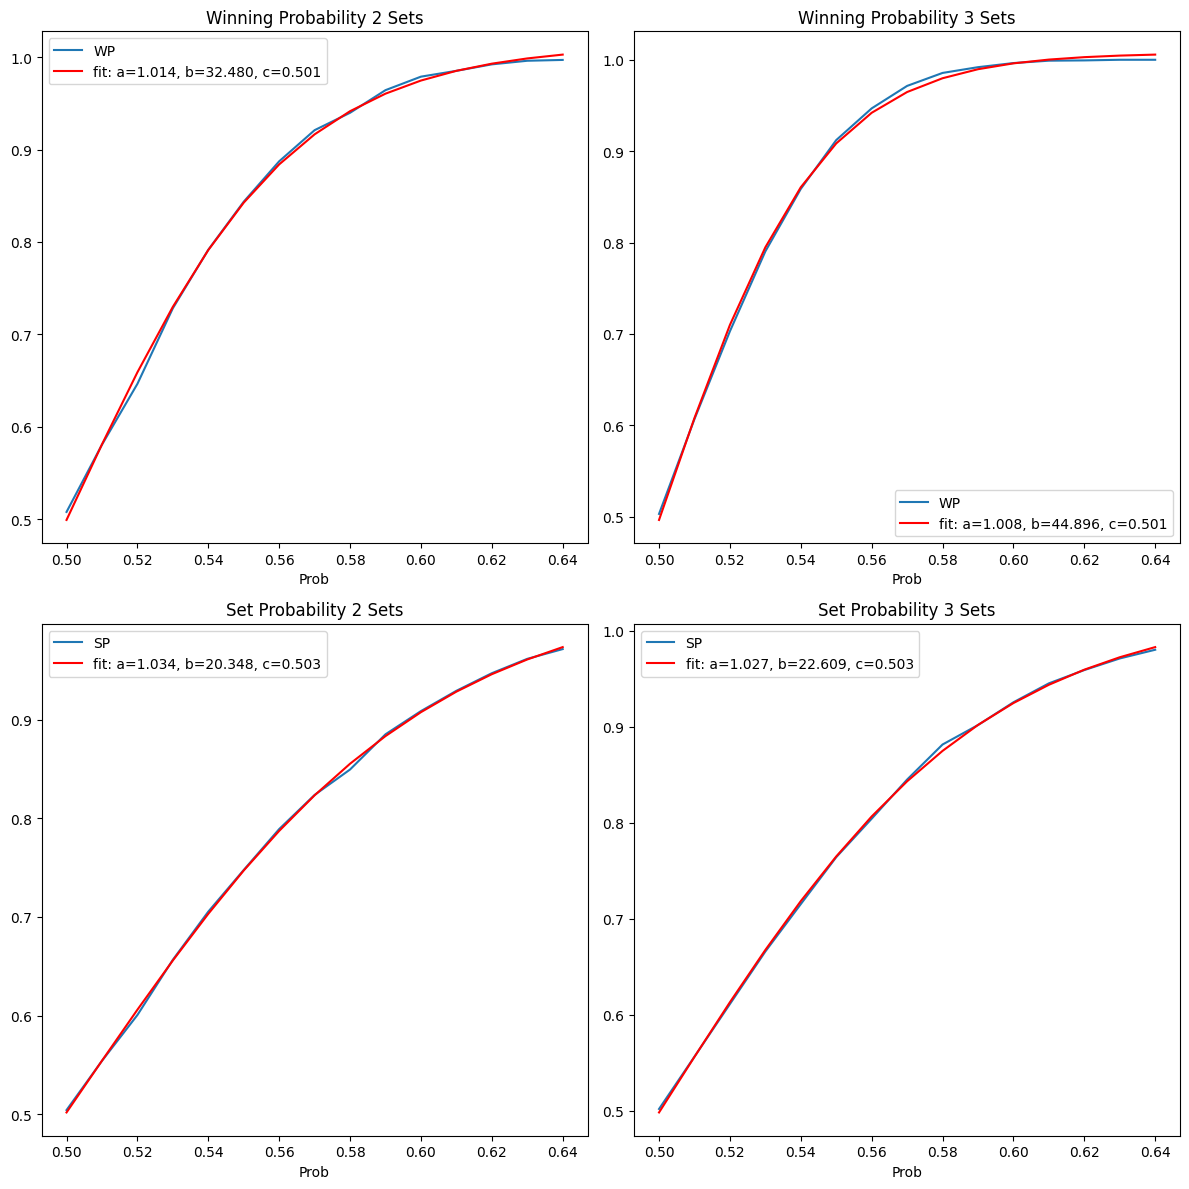

In [4]:
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats
import matplotlib.pyplot as plt

def func(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

def fit_curve(df, column):
    popt, pcov = curve_fit(func, df['Prob'], df[column])
    return popt

popt_2sets_WP = fit_curve(df_2sets, 'WP')
popt_3sets_WP = fit_curve(df_3sets, 'WP')
popt_2sets_SP = fit_curve(df_2sets, 'SP')
popt_3sets_SP = fit_curve(df_3sets, 'SP')

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

df_2sets.plot(x='Prob', y='WP', title='Winning Probability 2 Sets', ax=axs[0, 0]);
axs[0, 0].plot(df_2sets['Prob'], func(df_2sets['Prob'], *popt_2sets_WP), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_2sets_WP))

df_3sets.plot(x='Prob', y='WP', title='Winning Probability 3 Sets', ax=axs[0, 1]);
axs[0, 1].plot(df_3sets['Prob'], func(df_3sets['Prob'], *popt_3sets_WP), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_3sets_WP))

df_2sets.plot(x='Prob', y='SP', title='Set Probability 2 Sets', ax=axs[1, 0]);
axs[1, 0].plot(df_2sets['Prob'], func(df_2sets['Prob'], *popt_2sets_SP), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_2sets_SP))

df_3sets.plot(x='Prob', y='SP', title='Set Probability 3 Sets', ax=axs[1, 1]);
axs[1, 1].plot(df_3sets['Prob'], func(df_3sets['Prob'], *popt_3sets_SP), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_3sets_SP))

for ax in axs.flat:
    ax.legend()

plt.tight_layout()

## Fit using a Bernoulli trial model
We can model a set as a Bernoulli trial, answering the question of getting at least $k$ successes before the $r-th$ failure where $k$ and $r$ are the same: the number of points needed to win a set. Similarly, we can apply the same formula to the probability of winning a match given the probability of winning a set.

The approximation works quite well, despite the imperfection of having to win a set by at least 2 points, which is not considered in the analytical formula, but it is in the simulation. My intuition is that once you get to 24-24 and continue playing, the probability doesn't change.

The formula is taken from [here](https://math.stackexchange.com/questions/915353/the-probability-of-having-k-successes-before-r-failures-in-a-sequence-of-ind).

It is this:

$$ P = \sum_{j=0}^{r-1} \binom{k-1+j}{k-1} p^k (1-p)^j $$

My intuitive explanation for the formula above follows.

Imagine you want the probability of 3 successes before 3 failures, given the probability of success $p$.

There is just one way to get to 3-0, by 3 successes in a row -> WWW

$ P(3-0) = p^3 $

There are 4 ways to get to 3-1, but WWWL doesn't count as the match stops at 3-0, hence we are left with LWWW WLWW WWLW.
Which can be tought of as 'all the way to pick 2 wins out out of the first 3 slots, hence $\binom{3}{2}$.

$P(3-1) =  \binom{3}{2} p^3 (1 - p)^1$

Equally, you can think at the binomial below as all the ways to get 2 wins in the first 4 slots.

$ P(3-2) = \binom{4}{2} p^3 (1-p)^2 $

The fit is pretty good here too, but now we have a theoretical explanation for it, which is always nice.

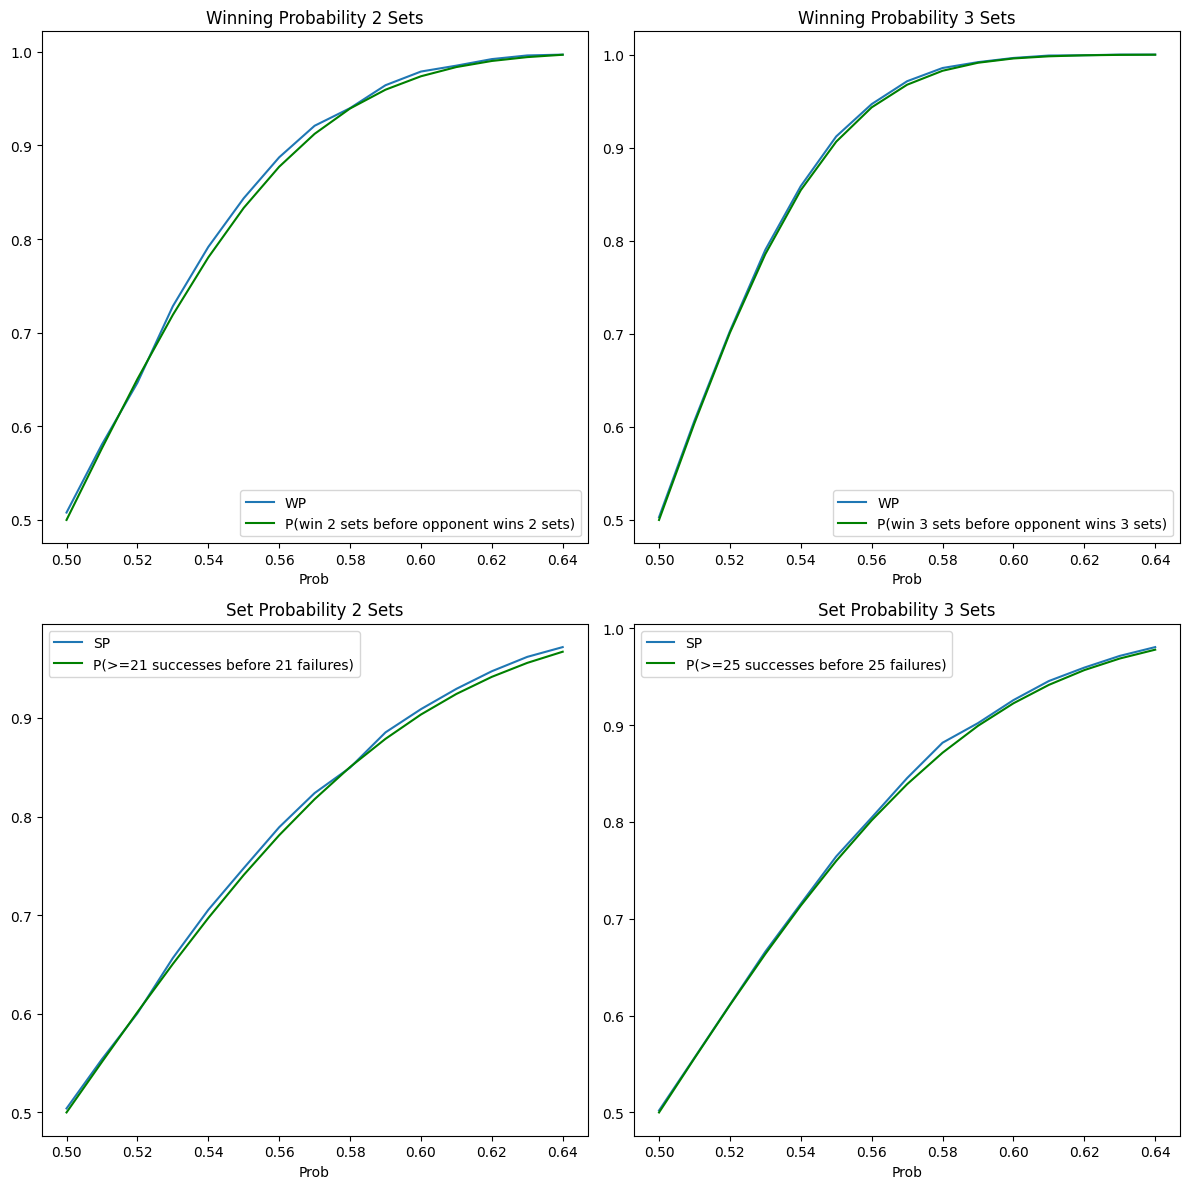

In [5]:
from scipy.special import comb

# Range ends in j instead of j-1 as in the formula because the range function is exclusive
def prob_at_least_k_successes_before_r_failures(k, r):
    return lambda x: sum([comb(k - 1 + j, k -1 ) * x**k * (1 - x)** j for j in range(0, r)])

prob_at_least_21 = lambda x: prob_at_least_k_successes_before_r_failures(21, 21)(x)
prob_at_least_25 = lambda x: prob_at_least_k_successes_before_r_failures(25, 25)(x)

prob_win_2sets = lambda x: prob_at_least_k_successes_before_r_failures(2, 2)(prob_at_least_21(x))
prob_win_3sets = lambda x: prob_at_least_k_successes_before_r_failures(3, 3)(prob_at_least_25(x))

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

df_2sets.plot(x='Prob', y='WP', title='Winning Probability 2 Sets', ax=axs[0, 0]);
axs[0, 0].plot(df_2sets['Prob'], prob_win_2sets(df_2sets['Prob']), 'g-', label='P(win 2 sets before opponent wins 2 sets)')

df_3sets.plot(x='Prob', y='WP', title='Winning Probability 3 Sets', ax=axs[0, 1]);
axs[0, 1].plot(df_2sets['Prob'], prob_win_3sets(df_2sets['Prob']), 'g-', label='P(win 3 sets before opponent wins 3 sets)')

df_2sets.plot(x='Prob', y='SP', title='Set Probability 2 Sets', ax=axs[1, 0]);
axs[1, 0].plot(df_2sets['Prob'], prob_at_least_21(df_2sets['Prob']), 'g-', label='P(>=21 successes before 21 failures)')

df_3sets.plot(x='Prob', y='SP', title='Set Probability 3 Sets', ax=axs[1, 1]);
axs[1, 1].plot(df_3sets['Prob'], prob_at_least_25(df_3sets['Prob']), 'g-', label='P(>=25 successes before 25 failures)')

# show labels
for ax in axs.flat:
    ax.legend()

plt.tight_layout()

## A linear approximation
In the more reasonable range, 0.50 - 0.55 a linear approximation works pretty good. So, if you are tight on resources, you can use this approximation without too much loss of fidelity.

6.837142857142849 -2.906399999999996
8.25314285714285 -3.6039333333333294


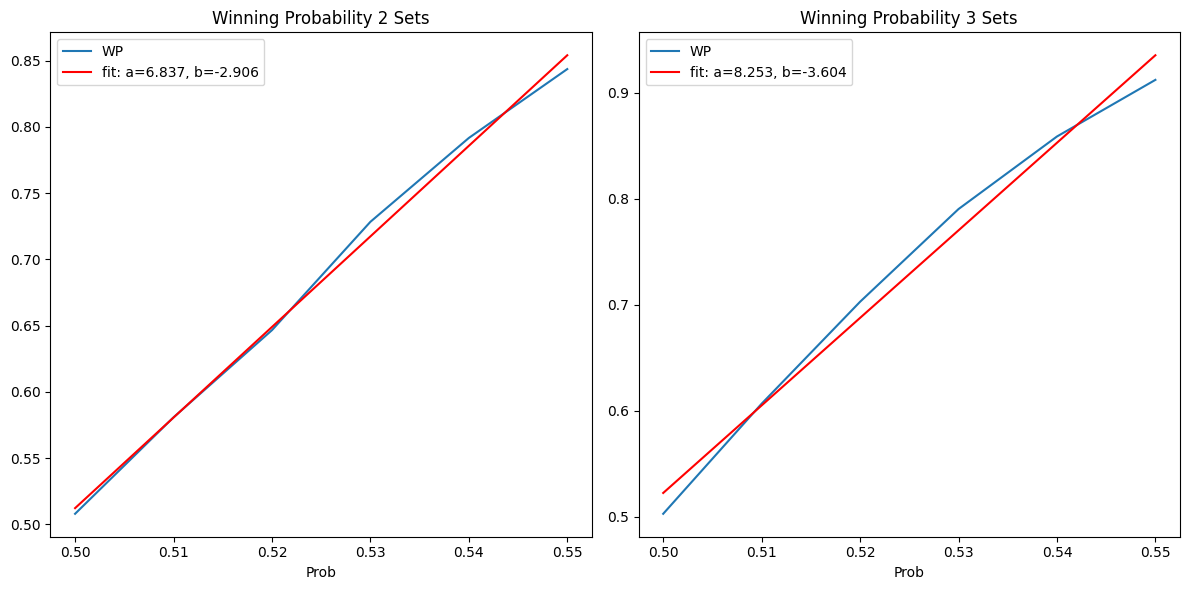

In [6]:
# Take just the rows with probability less than 0.56
df_2sets_low = df_2sets[df_2sets['Prob'] < 0.56]
df_3sets_low = df_3sets[df_3sets['Prob'] < 0.56]

# Do a linear fit on the data and plot the data and the fit
from scipy.stats import linregress

def fit_linear(df):
    slope, intercept, r_value, p_value, std_err = linregress(df['Prob'], df['WP'])
    return slope, intercept

slope_2sets, intercept_2sets = fit_linear(df_2sets_low)
slope_3sets, intercept_3sets = fit_linear(df_3sets_low)

print(slope_2sets, intercept_2sets)
print(slope_3sets, intercept_3sets)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

df_2sets_low.plot(x='Prob', y='WP', title='Winning Probability 2 Sets', ax=axs[0]);
axs[0].plot(df_2sets_low['Prob'], slope_2sets * df_2sets_low['Prob'] + intercept_2sets, 'r-', label='fit: a=%5.3f, b=%5.3f' % (slope_2sets, intercept_2sets))

df_3sets_low.plot(x='Prob', y='WP', title='Winning Probability 3 Sets', ax=axs[1]);
axs[1].plot(df_3sets_low['Prob'], slope_3sets * df_3sets_low['Prob'] + intercept_3sets, 'r-', label='fit: a=%5.3f, b=%5.3f' % (slope_3sets, intercept_3sets))

# show labels
for ax in axs:
    ax.legend()

plt.tight_layout()

## Conclusion
The probability of winning a set/match is not linear with the probability of winning a point and it is much higher. The longer the set/match, the more the probability of winning a set/match is higher than the probability of winning a point. A sigmoid function fits the data pretty well, but a linear approximation works well in the range 0.50-0.55. A Bernoulli trial model can be used to approximate the probability of winning a set/match given the probability of winning a point.